## imports & helper functions

In [ ]:
# A. Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, f1_score, precision_score, recall_score

import joblib
import shap


## load raw file (pipe-separated) and basic cleaning

In [ ]:
# B. Load
raw_path = r"C:\Users\Dell\Pictures\acis-insurance-eda\data\raw\MachineLearningRating_v3.txt"
df = pd.read_csv(raw_path, sep='|', parse_dates=['TransactionMonth'], low_memory=False)

# quick head & info
print("Loaded shape:", df.shape)
display(df.head(3))

Loaded shape: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


## normalize numeric columns (strings like '.000000000000' → numeric)

In [ ]:
# C. Convert Totals to numeric safely
for col in ['TotalPremium', 'TotalClaims', 'CalculatedPremiumPerTerm', 'CustomValueEstimate', 'SumInsured']:
    if col in df.columns:
        # remove stray characters and coerce to numeric
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')

# Create HasClaim binary
df['HasClaim'] = (df['TotalClaims'].fillna(0) > 0).astype(int)

# Extract time features from TransactionMonth
if 'TransactionMonth' in df.columns:
    df['Year'] = df['TransactionMonth'].dt.year
    df['Month'] = df['TransactionMonth'].dt.month
    df['Day'] = df['TransactionMonth'].dt.day
    df['Hour'] = df['TransactionMonth'].dt.hour


## quick EDA & column selection (choose model features)

In [ ]:
# D. Inspect missingness for candidate features (first pass)
display(df[['TotalPremium','TotalClaims','CalculatedPremiumPerTerm','CustomValueEstimate']].describe())
print("Gender unique:", df['Gender'].unique()[:10])
print("Province unique count:", df['Province'].nunique())

# Choose features for modeling — start with sensible fields
# Remove identifiers & verbose text fields. Keep policy / exposure variables.
drop_cols = ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'VehicleIntroDate', 'Comments']  # adjust if present
candidate_features = [c for c in df.columns if c not in drop_cols + ['TotalClaims','HasClaim']]

# Narrow to a manageable set (you can expand later)
# pick features that are likely predictive and present in sample:
features = [
    'Year','Month','Make','Model','VehicleType','RegistrationYear','Cylinders',
    'cubiccapacity','kilowatts','NumberOfDoors','CustomValueEstimate',
    'Province','PostalCode','SumInsured','CalculatedPremiumPerTerm','Gender'
]
# keep only those that exist
features = [f for f in features if f in df.columns]
print("Features used:", features)


,TotalPremium,TotalClaims,CalculatedPremiumPerTerm,CustomValueEstimate
count,1.000077e+06,1.000098e+06,1.000098e+06,2.204560e+05
mean,6.190680e+01,6.486119e+01,1.178757e+02,2.255311e+05
std,2.302868e+02,2.384075e+03,3.997017e+02,5.645157e+05
min,-7.825768e+02,-1.200241e+04,0.000000e+00,2.000000e+04
25%,0.000000e+00,0.000000e+00,3.224800e+00,1.350000e+05
50%,2.178333e+00,0.000000e+00,8.436900e+00,2.200000e+05
75%,2.192982e+01,0.000000e+00,9.000000e+01,2.800000e+05
max,6.528260e+04,3.930921e+05,7.442217e+04,2.655000e+07


Gender unique: ['Not specified' 'Male' 'Female' nan]
Province unique count: 9
Features used: ['Year', 'Month', 'Model', 'VehicleType', 'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'CustomValueEstimate', 'Province', 'PostalCode', 'SumInsured', 'CalculatedPremiumPerTerm', 'Gender']


## prepare datasets for the two tasks

In [ ]:
# E1: Regression dataset (claim severity) — only policies with claims
df_reg = df[df['TotalClaims'] > 0].copy()
X_reg = df_reg[features].copy()
y_reg = df_reg['TotalClaims'].astype(float).copy()

# E2: Classification dataset (claim occurrence)
X_clf = df[features].copy()
y_clf = df['HasClaim'].copy()

print("Regression rows:", X_reg.shape, "Classification rows:", X_clf.shape)

Regression rows: (2788, 15) Classification rows: (1000098, 15)


## preprocessing pipelines (robust)

In [ ]:
# F. Preprocessing: detect numeric and categorical
numeric_feats = X_reg.select_dtypes(include=['number']).columns.tolist()
categorical_feats = [c for c in features if c not in numeric_feats]

print("Numeric:", numeric_feats)
print("Categorical:", categorical_feats)

# Numeric pipeline: median imputer + standard scaler
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Categorical pipeline: constant for missing + one-hot (ignore unknowns)
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, categorical_feats)
], remainder='drop')


Numeric: ['Year', 'Month', 'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'CustomValueEstimate', 'PostalCode', 'SumInsured', 'CalculatedPremiumPerTerm']
Categorical: ['Model', 'VehicleType', 'Province', 'Gender']


## train/test split and model pipelines

In [ ]:
# G. Split (regression)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Regression pipelines for three models
pipe_lr = Pipeline([('prep', preprocessor), ('model', LinearRegression())])
pipe_rf = Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
pipe_xgb = Pipeline([('prep', preprocessor), ('model', XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=4))])

# Fit (regression)
print("Training LinearRegression...")
pipe_lr.fit(Xr_train, yr_train)
print("Training RandomForest...")
pipe_rf.fit(Xr_train, yr_train)
print("Training XGBoost...")
pipe_xgb.fit(Xr_train, yr_train)


Training LinearRegression...
Training RandomForest...
Training XGBoost...


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## evaluate regression models

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_reg(pipe, X_test, y_test, name):
    y_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)   # ✅ manual square root
    r2 = r2_score(y_test, y_pred)

    print(f"{name} — RMSE: {rmse:.3f}, R2: {r2:.3f}")
    return rmse, r2

print("---- Evaluation (regression) ----")
evaluate_reg(pipe_lr, Xr_test, yr_test, "LinearRegression")
evaluate_reg(pipe_rf, Xr_test, yr_test, "RandomForest")
evaluate_reg(pipe_xgb, Xr_test, yr_test, "XGBoost")



---- Evaluation (regression) ----
LinearRegression — RMSE: 38519.766, R2: 0.077
RandomForest — RMSE: 36555.767, R2: 0.169
XGBoost — RMSE: 37650.448, R2: 0.119


(np.float64(37650.44808249581), 0.1185711094758175)

## classification model (probability of claim)

In [ ]:
# Split classification data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# classifier pipeline
clf_pipe = Pipeline([('prep', preprocessor), ('model', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
clf_pipe.fit(Xc_train, yc_train)

# evaluate classification
y_proba = clf_pipe.predict_proba(Xc_test)[:,1]
y_pred = clf_pipe.predict(Xc_test)
print("Classification AUC:", roc_auc_score(yc_test, y_proba))
print("Precision / Recall / F1:", precision_score(yc_test, y_pred), recall_score(yc_test, y_pred), f1_score(yc_test, y_pred))

Classification AUC: 0.634726811460018
Precision / Recall / F1: 0.022388059701492536 0.0051635111876075735 0.008391608391608392


### Save Regressor Feature Schema (RUN THIS ONCE, RIGHT AFTER TRAINING)

In [ ]:
# ✅ Save the raw feature schema used by the regressor
regressor_raw_columns = Xr_train.columns


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Define numeric and categorical features
numeric_feats = Xr_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_feats = Xr_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, categorical_feats)
])

# Full pipeline
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Fit on training data
pipe_rf.fit(Xr_train, yr_train)

# Predict on raw test data
pred_severity = pipe_rf.predict(Xc_test)


## compute conceptual risk-based premium for test set

In [ ]:
# ================================
# ✅ RISK-BASED PREMIUM PIPELINE
# ================================

# 1. Claim probability from classifier
pred_prob = clf_pipe.predict_proba(Xc_test)[:, 1]

# 2. ✅ Align raw columns EXACTLY to what the regressor saw
Xc_test_aligned = Xc_test.reindex(columns=regressor_raw_columns)

# 3. ✅ Predict claim severity safely
pred_severity = pipe_rf.predict(Xc_test_aligned)

# 4. Risk-based premium formula
loading = 0.10
risk_premium = (pred_prob * pred_severity) * (1 + loading)

# 5. Final comparison table
premium_df = pd.DataFrame({
    "Predicted_Claim_Probability": pred_prob,
    "Predicted_Claim_Severity": pred_severity,
    "Risk_Based_Premium": risk_premium,
    "Actual_TotalPremium": yc_test.values
})

premium_df.head()


,Predicted_Claim_Probability,Predicted_Claim_Severity,Risk_Based_Premium,Actual_TotalPremium
0,0.0,4283.950409,0.0,0
1,0.0,4461.720582,0.0,0
2,0.0,6024.314456,0.0,0
3,0.0,4365.101360,0.0,0
4,0.0,4887.883539,0.0,0


## Fit preprocessor once on the training data

In [ ]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, categorical_feats)
])
preprocessor.fit(Xr_train)  # fit only once


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## Use the same preprocessor in all pipelines

In [ ]:
pipe_lr = Pipeline([('prep', preprocessor), ('model', LinearRegression())])
pipe_rf = Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
pipe_xgb = Pipeline([('prep', preprocessor), ('model', XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=4))])


In [ ]:
pipe_lr.fit(Xr_train, yr_train)
pipe_rf.fit(Xr_train, yr_train)
pipe_xgb.fit(Xr_train, yr_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Transform test set using the same preprocessor

In [ ]:
Xr_test_trans = preprocessor.transform(Xr_test)
Xc_test_trans = preprocessor.transform(Xc_test)


## Predict using the model steps directly

In [ ]:
y_pred_lr = pipe_lr.named_steps['model'].predict(Xr_test_trans)
y_pred_rf = pipe_rf.named_steps['model'].predict(Xr_test_trans)
y_pred_xgb = pipe_xgb.named_steps['model'].predict(Xr_test_trans)


In [ ]:
# Compute predicted probabilities using the full pipelines
y_proba_logreg = pipe_logreg.predict_proba(Xc_test)[:, 1]
y_proba_rf     = pipe_rf_clf.predict_proba(Xc_test)[:, 1]
y_proba_xgb    = pipe_xgb_clf.predict_proba(Xc_test)[:, 1]

# Compute ROC-AUC scores
from sklearn.metrics import roc_auc_score

roc_auc_logreg = roc_auc_score(yc_test, y_proba_logreg)
roc_auc_rf     = roc_auc_score(yc_test, y_proba_rf)
roc_auc_xgb    = roc_auc_score(yc_test, y_proba_xgb)

print("ROC-AUC Scores:")
print(f"Logistic Regression: {roc_auc_logreg:.3f}")
print(f"Random Forest:       {roc_auc_rf:.3f}")
print(f"XGBoost:             {roc_auc_xgb:.3f}")


ROC-AUC Scores:
Logistic Regression: 0.633
Random Forest:       0.635
XGBoost:             0.907


## Compute ROC

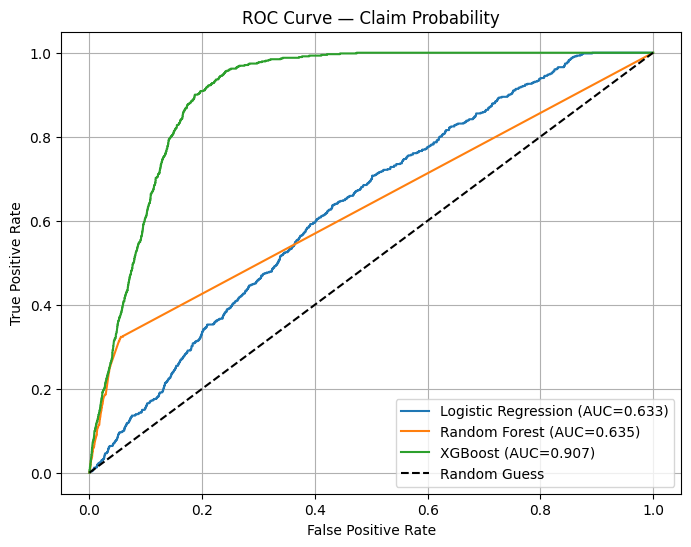

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(yc_test, y_proba_logreg)
fpr_rf, tpr_rf, _         = roc_curve(yc_test, y_proba_rf)
fpr_xgb, tpr_xgb, _       = roc_curve(yc_test, y_proba_xgb)

# Compute AUCs
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf     = auc(fpr_rf, tpr_rf)
auc_xgb    = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC={auc_logreg:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Claim Probability')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Summary Plot
Each point represents a single policy in the test set.

The color indicates the feature value (red=high, blue=low).

The x-axis shows the SHAP value (impact on the model output).

This plot highlights both the magnitude and direction of influence for the top features on predicted claim severity.

SHAP Summary Dot Plot — shows feature impact on predicted claim severity


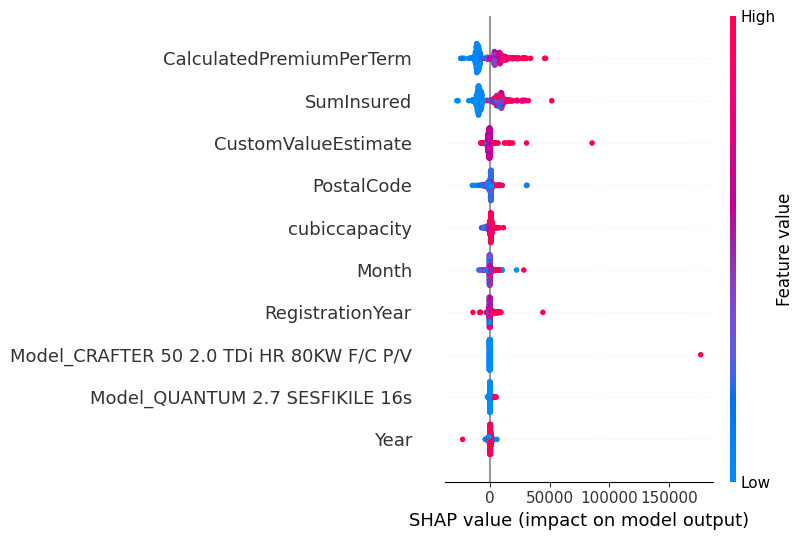

In [ ]:
import shap

# Transform test set using preprocessor
X_test_trans = preprocessor.transform(Xr_test)

# Convert to dense array if sparse
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()
else:
    X_test_trans = np.array(X_test_trans, dtype=np.float64)

# Feature names (numeric + one-hot categorical)
num_names = numeric_feats
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(categorical_feats).tolist()
feature_names = num_names + cat_names

# SHAP Explainer
model_xgb = pipe_xgb.named_steps['model']
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_trans)

# Summary Dot Plot
print("SHAP Summary Dot Plot — shows feature impact on predicted claim severity")
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names, max_display=10)


## SHAP Feature Importance Bar Plot
Bars represent the average absolute SHAP value per feature.

Longer bars = higher overall impact on model predictions.

Provides a simple ranking of which features the model relies on most.

SHAP Feature Importance Bar Plot — shows average magnitude of feature impact


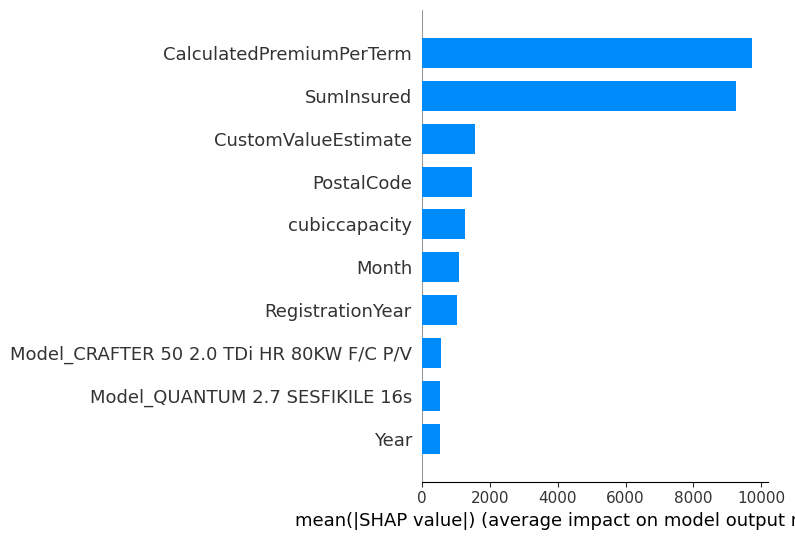

In [ ]:
# Bar Plot
print("SHAP Feature Importance Bar Plot — shows average magnitude of feature impact")
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names, plot_type='bar', max_display=10)
